All TPOT estimators can be created with the TPOTEstimator class. 
The TPOTClassifier and TPOTRegressor are set default parameters for the TPOTEstimator for Classification and Regression.

In [1]:
import tpot2
import sklearn
import sklearn.datasets

est = tpot2.TPOTEstimator(  population_size=30,
                            generations=5,
                            scorers=['roc_auc_ovr'], #scorers can be a list of strings or a list of scorers. These get evaluated during cross validation. 
                            scorers_weights=[1],
                            classification=True,
                            n_jobs=1, 
                            early_stop=5, #how many generations with no improvement to stop after
                            
                            #List of other objective functions. All objective functions take in an untrained GraphPipeline and return a score or a list of scores
                            other_objective_functions= [ tpot2.estimator_objective_functions.average_path_length_objective,  tpot2.estimator_objective_functions.number_of_nodes_objective],
                            
                            #List of weights for the other objective functions. Must be the same length as other_objective_functions. By default, bigger is better is set to True. 
                            other_objective_functions_weights=[-1, -1],
                            verbose=1)

scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X, y = sklearn.datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Generation:   0%|          | 0/5 [00:00<?, ?it/s]

1.0


/home/ribeirop/miniconda3/envs/tpot2env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


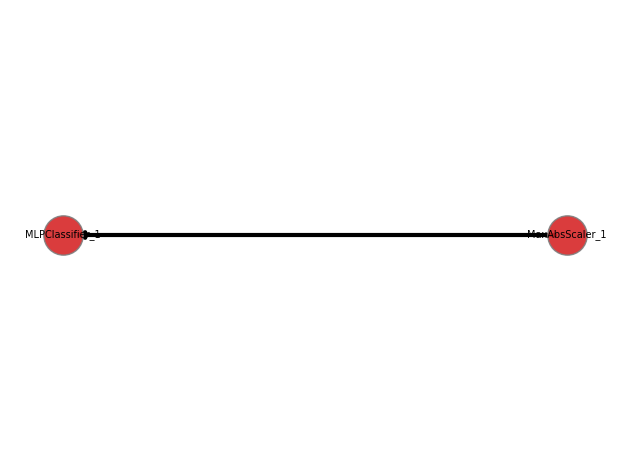

In [2]:
fitted_pipeline = est.fitted_pipeline_ # access best pipeline directly
fitted_pipeline.plot()

In [3]:
#view the summary of all evaluated individuals as a pandas dataframe
est.evaluated_individuals

,roc_auc_score,average_path_length_objective,number_of_nodes_objective,Parents,Variation_Function,Individual,Generation,Pareto_Front,Instance
0,0.997698,1.0,1.0,NaN,NaN,<tpot2.representations.graph_pipeline_individu...,0.0,0.0,GraphPipeline(graph=<networkx.classes.digraph....
1,0.949345,1.0,1.0,NaN,NaN,<tpot2.representations.graph_pipeline_individu...,0.0,26.0,GraphPipeline(graph=<networkx.classes.digraph....
2,0.983175,1.0,1.0,NaN,NaN,<tpot2.representations.graph_pipeline_individu...,0.0,18.0,GraphPipeline(graph=<networkx.classes.digraph....
3,INVALID,INVALID,INVALID,NaN,NaN,<tpot2.representations.graph_pipeline_individu...,0.0,NaN,GraphPipeline(graph=<networkx.classes.digraph....
4,0.98881,1.0,1.0,NaN,NaN,<tpot2.representations.graph_pipeline_individu...,0.0,11.0,GraphPipeline(graph=<networkx.classes.digraph....
...,...,...,...,...,...,...,...,...,...
145,0.990913,1.666667,3.0,"(84,)",mutate,<tpot2.representations.graph_pipeline_individu...,4.0,16.0,GraphPipeline(graph=<networkx.classes.digraph....
146,0.997698,1.0,1.0,"(113,)",mutate,<tpot2.representations.graph_pipeline_individu...,4.0,0.0,GraphPipeline(graph=<networkx.classes.digraph....
147,0.997698,1.5,2.0,"(84,)",mutate,<tpot2.representations.graph_pipeline_individu...,4.0,5.0,GraphPipeline(graph=<networkx.classes.digraph....
148,0.966627,1.5,2.0,"(113,)",mutate,<tpot2.representations.graph_pipeline_individu...,4.0,22.0,GraphPipeline(graph=<networkx.classes.digraph....


In [4]:
#view pareto front as a pandas dataframe
est.pareto_front

,roc_auc_score,average_path_length_objective,number_of_nodes_objective,Parents,Variation_Function,Individual,Generation,Pareto_Front,Instance
0,0.997698,1.0,1.0,NaN,NaN,<tpot2.representations.graph_pipeline_individu...,0.0,0.0,GraphPipeline(graph=<networkx.classes.digraph....
25,0.997698,1.0,1.0,NaN,NaN,<tpot2.representations.graph_pipeline_individu...,0.0,0.0,GraphPipeline(graph=<networkx.classes.digraph....
30,0.997698,1.0,1.0,"(25, 0)",crossover_and_mutate,<tpot2.representations.graph_pipeline_individu...,1.0,0.0,GraphPipeline(graph=<networkx.classes.digraph....
32,0.997698,1.0,1.0,"(25, 0)",crossover_and_mutate,<tpot2.representations.graph_pipeline_individu...,1.0,0.0,GraphPipeline(graph=<networkx.classes.digraph....
33,0.997698,1.0,1.0,"(0,)",mutate,<tpot2.representations.graph_pipeline_individu...,1.0,0.0,GraphPipeline(graph=<networkx.classes.digraph....
44,0.997698,1.0,1.0,"(0,)",mutate,<tpot2.representations.graph_pipeline_individu...,1.0,0.0,GraphPipeline(graph=<networkx.classes.digraph....
48,0.997698,1.0,1.0,"(25,)",mutate,<tpot2.representations.graph_pipeline_individu...,1.0,0.0,GraphPipeline(graph=<networkx.classes.digraph....
54,0.997698,1.0,1.0,"(0,)",mutate,<tpot2.representations.graph_pipeline_individu...,1.0,0.0,GraphPipeline(graph=<networkx.classes.digraph....
57,0.997698,1.0,1.0,"(25,)",mutate,<tpot2.representations.graph_pipeline_individu...,1.0,0.0,GraphPipeline(graph=<networkx.classes.digraph....
63,0.997698,1.0,1.0,"(25,)",mutate,<tpot2.representations.graph_pipeline_individu...,2.0,0.0,GraphPipeline(graph=<networkx.classes.digraph....


In [5]:
import tpot2
import sklearn
import sklearn.metrics
import sklearn.datasets

est = tpot2.tpot_estimator.templates.TPOTRegressor(population_size=30,
                                                   generations=2,
                                                   verbose=1)


'''
This is equivalent to:
est = tpot2.TPOTEstimator(  population_size=30,
                            generations=2
                            scorers = ['neg_mean_squared_error'],
                            scorers_weights = [1],
                            classification = False,
                            verbose=1)

'''


scorer = sklearn.metrics.get_scorer('neg_mean_squared_error')
X, y = sklearn.datasets.load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Generation:   0%|          | 0/2 [00:00<?, ?it/s]

-3186.367185615181


In [6]:
import tpot2
import sklearn
import sklearn.datasets

est = tpot2.tpot_estimator.templates.TPOTClassifier(population_size=30,
                                                    generations=2,
                                                    verbose=1)

'''
This is equivalent to:
est = tpot2.TPOTEstimator(  population_size=30,
                            generations=2
                            scorers = ['roc_auc_ovo'],
                            scorers_weights = [1],
                            classification=True,
                            verbose=1)

'''


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X, y = sklearn.datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

Generation:   0%|          | 0/2 [00:00<?, ?it/s]

0.9997482955022637
